## Imports

In [1]:
# Basics 
import numpy as np
import sys
import pickle
import os

# plotting 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline 
from IPython.display import Image,display

# Scipy 
import scipy 
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import truncnorm
from scipy.optimize import linprog
from scipy.io import loadmat

In [2]:
# my code 
sys.path.append('./')
sys.path.append('../shared')

from nCVaR_Value_Iteration import nCVaR_VI
from scenarios import Agent, setup_params
from shared import induce_P

## Load MDP from Matlab

In [3]:
# load old matlab results, which have useful info for MDP
mat = loadmat('../simulation_results/1D_optimal_policy.mat')

# Unpack 
Ny = mat['Y_set_all'].shape[1]
Ns = mat['Y_set_all'].shape[0] # could subtract one here 
Na = 3
gamma = mat['dis'][0][0]
y_set = mat['Y_set_all'][0,:]
Pol_CVaR = mat['Pol_CVaR']
P = mat['P']
r = mat['r']
print(P.shape)
print("x,x',a")

(10, 10, 3)
x,x',a


In [4]:
testcase = 4
subcase = 'aS'
p,maze = setup_params(testcase) 
agent = Agent({'num_states':Ns-1,
               'num_actions':Na,
               'start_states':[4],'r_params':p['r_params']},maze)

## Running Dynamic Risk Measure Value Iteration


In [5]:
# Run Policy Iteration
V0 = np.repeat((mat['V_Exp']/10),Ny,1)*0; # initialize to 0
P_full = np.repeat(P[:,:,np.newaxis,:],Ny,axis=2) # broadcast across Y dimension
r_x = r[:,0]

(Vd,Qd,Xid,Pid,V_storaged,Q_storaged,Xi_storaged,
 pointwise_errord,V_convergedd,multi_startsd) = nCVaR_VI(V0,
            Ns,Ny,Na,
            P_full,
            gamma,
            y_set,
            r_x, # only per state 
            check_pointwise_iters=3,
            pointwise_window=3,
            min_multi_starts=2,
            max_multi_starts=5,
            max_iters=100,
            verbose=False,
            converg_thresh = 10e-5,
            yi_pr=None,
            converg_type = 'full_eval')

/kyb/agpd/cgagne/miniconda3/envs/env_cvar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Converged in iters=87
max error=9.351432076165622e-05
at x=8 y=5
--- 119.31516003608704 seconds ---


## Save 

In [10]:
fname = '../simulation_results/1D_optimal_policy_nCVaR.npz'
fname

'../simulation_results/1D_optimal_policy_nCVaR.npz'

In [11]:
np.savez(fname,*[Vd,Xid,V_storaged,Qd,Q_storaged,Xid,Xi_storaged,Pid])

## Load 

In [12]:
# Load 
container = np.load(fname)
data = [container[key] for key in container]
Vd = data[0]
Xid = data[1]
V_storaged=data[2]
Qd = data[3]
Q_storaged = data[4]
Xid = data[5]
Xi_storaged = data[6]
Pid = data[7]

## Convergence 

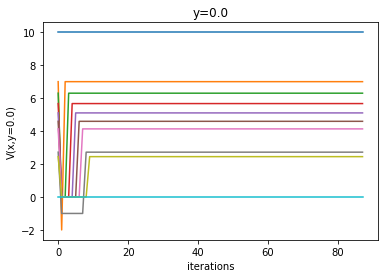

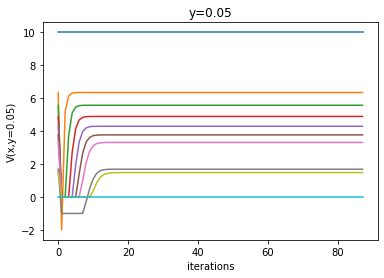

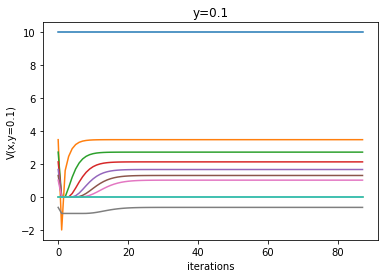

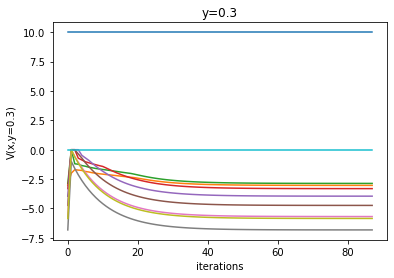

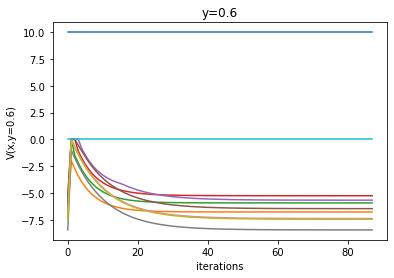

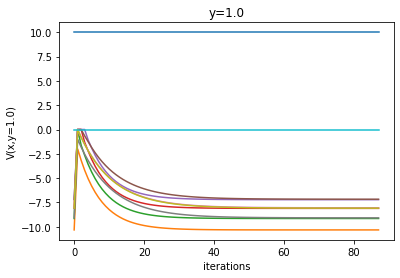

In [33]:
for y in np.arange(6): #[1,5,11,15,18,20]:
    plt.figure()
    plt.title('y='+str(np.round(y_set[y],2)))
    plt.plot(V_storaged[:,:,y]);
    plt.xlabel('iterations')
    plt.ylabel('V(x,y='+str(np.round(y_set[y],2))+')')